# MANP problem (*M*aximizing *A*verage *N*umber of *P*ages read in multi-page publications) as an MDP

<hr style="border:0.5px solid gray"> </hr>

### Contents:
1. [Introduction](#intro)
2. [Formal MDP definition](#formal)
3. [MDP Implementation](#impl)<br>
    a.[Basic objects](#basic)<br>
    b.[MDP basic elements](#elem)<br>
4. [Tests of the MDP](#tests)<br>
    a.[Test1](#test1)<br>
    b.[Test2](#test2)<br>
5. [Temporary conclusion](#conclude)

<hr style="border:0.5px solid gray"> </hr>

## Introduction
<a id='intro'></a>

In this section we will present MANP problem as MDP. In order to simplify the representation at this stage we add two constraints on the initial model:
1. On each step the agent has only two possible actions - "next" and "leave".
2. The agent can't visit the same page twice.

The problem remains the same: given a set of content units (pages)  $B = \{c_1\dots c_K\}$, we want to present it to users in such a way that will maximize the average number of pages viewed. The only thing we can change is an order of the representation for each particular user.<br>

Even though the naive and straightforward way to define the MDP is to set the content consumer being an agent, we will do it in a different way. The content producer will be an agent and the Web resource visitor will be the part of the environment. Such a formulation allows us to use classic tools of planning to optimize the target MANP problem's value.



## Formal MDP definition
<a id='formal'></a>


<hr style="border:2px solid gray"> </hr>

**Here is a definition of the MDP:**<br>

 1. State space $S = S' \cup \{s_{init},s_{final}\}$ : 
    * There will be an initial state $s_{init}$. The visitor haven't seen yet any content.
    * Each state $s_j = C_k \in S'$ will contain all the pages the user saw $C_k \subset B$ (nodes the user visited).
    * There will be a final state $s_{final}$. It represents the fact that the user finished watching the pages.
 <br> <br> 
 2.  Action space $A=\{a_{c_1}\dots a_{c_k}\}$. Action $a_{c_k}$ denotes the action of presenting  to the visitor page $c_k \in B$.
 <br><br>
 3.  Reward function $R(a,s,s')$ for $a \in A\;s,s'\in S$  depends only on the resulting state $s'$ :
     * If the agent traversed to $s_{final}$, the reward is zero. Otherwise it's 1.<br>
        $\forall a\in A\;s_i\in S :R(a,s_i,s_{final}) = 0$, otherwise $R(a,s,s')=1$
 <br><br>
 4. Transition function $T(a,s,s')$ depends only on action $a$ and it is not known to us. We will denote it as $T'(a) = T(a,s,s')$<br>
   It actually determines possible reactions of the content consumer to the page $c_i$ (or for action $a_{c_i}$ in terms of MDP) , the probability that the user press "next" or "leave". <br>
   At the next stages we may assume that it depends also on $s$ ,i.e. visitors behavior depends on the pages seen.
<hr style="border:2px solid gray"> </hr>

##### Policy
For this model the policy is an objective for an optimization, the content producer needs to learn the best way to present the user the content units. The goal is not only learning the optimal policy but doing it as fast as possible, or in terms of learning - by accumulating as less regret as possible.

##  MDP Implementation
<a id='impl'></a>

[POMDPs.jl](https://github.com/JuliaPOMDP/POMDPs.jl) package will be used to help modeling the MDP. It provides flexible interface that is compatable with different tools for solving and simulating an MDP. It specifies the set of functions that should be implemented. In fact we overload the methods of POMDPs package to work with the process we define. 

In following several subsections we implement this methods one by one and provide a short explanation for the  implementation.

##### Packages
<a id='basic'></a>

In [1]:
#
try
    using Pkg
    using POMDPs            # POMDPs.jl interface
    using POMDPModelTools   # POMDPModelTools has tools that help build the MDP definition
    using POMDPPolicies
    using POMDPSimulators
    using Combinatorics
    using DiscreteValueIteration
    using StatsPlots
    using Plots

catch  LoadError
    Pkg.add("POMDPs")
    Pkg.add("POMDPModelTools")
    Pkg.add("POMDPPolicies")
    Pkg.add("POMDPSimulators")
    Pkg.add("Combinatorics")
    Pkg.add("DiscreteValueIteration")
    Pkg.add("StatsPlots")
    Pkg.add("Plots")

    using DiscreteValueIteration
    using POMDPs
    using POMDPModelTools
    using POMDPPolicies
    using POMDPSimulators
    using Combinatorics
    using StatsPlots
    using Plots

end;

### Basic objects

Two basic objects of the model are **Page** and **User1**. 

 <span style='background:#D3D3D3'> User1 </span> object will encapsulate the particular user's behavior.
Although the user is a part of an environment in this model, and it may be fully described by the transition function of the process , we decided to represent it as a separate object. It was done for the several reasons: 
1. Preserving the initial structure of MANP problem , where the user is an essential part  
2. Having a convenient ability to change the user's behavior i.e simulating the arrival of different types of users 
3. Reusing the same object in other models of MANP problem.

<span style='background:#D3D3D3'> User1 </span> key attribute is <span style='background:#D3D3D3'> userPreferencesFunction </span> function. Given a pages seen so far and the current page shown her, the function returns the distribution on the possible user's reactions (leaving and proceeding).

<span style='background:#D3D3D3'> Page </span> is the object that represents the unit of content which the user consumes (watches) before deciding on her next action (leaving or proceeding) 



In [2]:
struct Page
   id :: Int64 
end

pages_collection = nothing

struct User1 
   id :: Int64
   userPreferencesFunction:: Any   # Recieve pages visited, current page shown
end;


#### Auxiliary functions

In [3]:
#
function CreatePages(number :: Int64)
    global pages_collection = [Page(id) for id in 1:number]
end

function BitArrToInt(arr)
    return sum(arr .* (2 .^ collect(0:length(arr)-1)))
    end;



### MDP basic elements
<a id='elem'></a>
#### States and Actions

In this section we define such a parts of the MDP as actions , states and the mdp object itself.
We remind that our representation, when the user is a part of the environment and the content provider is an agent, may seem counterintuitive at first sight. But it makes sense supposing that the goal is to maximize the number of pages viewed, which is a content provider's goal.

The <span style='background:#D3D3D3'> Action1</span>  object represents the action of presenting to the user a particular unit of content (aka page) .

The <span style='background:#D3D3D3'> State1</span> object specifies state. It contains the pages that the user already have seen and the indicator whether it is a terminal state.

In [4]:
struct Action1
   show_page :: Union{Page,Nothing}           # The page that is presented to the user
end

struct State1
    visited_pages :: Any                      # Didn't specified, because we need here immutable type.                                              # Supposed to be an immutable set
    if_terminal :: Bool
end 

#### MDP object
As a part of the POMDPs interface specifications , we should define an MDP object type <span style='background:#D3D3D3'> ContentProducerMdp </span>  that inherits from the abstract type MDP parametrized with the type of actions' and states' object. The structure contains the parameters of the MDP environment for MANP. It is passed as a first argument to all the POMDPs interface's functions to navigate to the implementations that was written for this concrete MDP. 

It will contain a current user that determine the process dynamics, array of content units (pages) as well as tools for tracking and statistics. 

In addition we define <span style='background:#D3D3D3'> MdpStatistics1 </span>, the object that aggregates the statistics for the concrete <span style='background:#D3D3D3'> ContentProducerMdp </span>.

In [5]:
mutable struct MdpStatistics1
   current_user_path :: Array{Page,1} 
   nexts_per_page :: Array{Int64,1}
    leaves_per_page :: Array{Int64,1}
    total_pages_seen :: Int64
    users_number :: Int64
    pages_seen_per_user :: Array{Int64,1}
    page_fialures_num :: Int64
    
end

mutable struct ContentProducerMdp <: MDP{State1,Action1}
    pages :: Array{Page,1}
    current_user :: User1
    statistics :: MdpStatistics1
    statistics_on :: Bool            # Whether the statistics should be collected
                                     # (Not neccessary for value iteration for example)
    
end



##### Auxiliary functions specified in POMDPs interface
Return the array of all the state and actions

In [6]:
function POMDPs.states(mdp::ContentProducerMdp)
    pages_superset = collect(powerset(mdp.pages))             # We assume that the function preserves the order (not in docs)
    states = [State1(Tuple(pages),false) for pages in pages_superset]  
    push!(states, State1(Tuple([]),true))
    return states
end

function POMDPs.actions(mdp::ContentProducerMdp)
    actions = [Action1(page) for page in mdp.pages]  
end

POMDPs.isterminal(mdp::ContentProducerMdp,s::State1)= return s.if_terminal

#### Transition function

In current less complicated formulation of the problem, the transition distribution depends only on the action. The user decision whether to proceed or to leave explained only by page that was presented him last.

Exactly two states have non-zero probabilities given action $a_i$. They are: 1) the final state and 2) the state that contains all the pages the user visited including the last one $c_i$. The transition distribution on these states is defined by the probability of the user to leave for each page. The transition function queries the current user to get it (userPreferencesFunction attribute of User1). <br>
Special case is when the visitor already saw all the pages, then the MDP is automatically traversed to the final state. 

In [7]:
function POMDPs.transition(mdp::ContentProducerMdp,state::State1,act::Action1)

    pages_visited = state.visited_pages
    current_page = act.show_page
    
    # Attemp to show the same page twice
    if current_page in pages_visited
        return SparseCat([State1(Tuple([]),true)], [1.0]) 
    end
    
    # Attemp to take action in the terminal state
    if POMDPs.isterminal(mdp,state)
       return SparseCat([State1(Tuple([]),true)], [1.0]) 
    end
    
    # All the pages have been seen by the user
    if length(pages_visited) == length(mdp.pages) - 1
       return SparseCat([State1(Tuple([]),true)], [1.0])
    end
    
    # Getting user's leaving probability
    leaving_probab = mdp.current_user.userPreferencesFunction(collect(Page,pages_visited),current_page)
    
    # Creating the next state
    #
    if length(pages_visited) == 0
        new_page_visited = [current_page]
    else
        new_page_visited = push!(collect(pages_visited),current_page)
    end
    
    # Sort the pages in the newly created state by id
    sort!(new_page_visited,by=page->page.id,alg=InsertionSort)  # The array is almost sorted , that's why insertion sort
    
    # Return distribution object on possible states
    return SparseCat([State1(Tuple(new_page_visited),false), State1(Tuple([]),true)],[1-leaving_probab,leaving_probab])
end

#### Reward function

The reward function is also simple and mostly depends on the destination state $s'$. If $s'$ is a final state, it means that the user leaved after seeing the last content unit and the reward is zero, and if $s'$ is non-terminal state then the user pressed "next" and the reward is 1.
The only case when the reward is positive and the visitor arrived at the final state is when she saw all the pages.
<br> **Remark:**<br>
In addition -100 reward was added when the page that was already seen and is proposed to the user again, it was done for out of the box POMDPs solvers, to prevent revisiting the pages.


In [8]:
function POMDPs.reward(mdp::ContentProducerMdp, state::State1, act::Action1, stateP::State1)
    
    # Collect statistics
    RecordStatistics(mdp, state, stateP, act)

    
    are_all_pages_seen = (POMDPs.isterminal(mdp,stateP) 
                        && length(state.visited_pages) >= (length(mdp.pages) - 1))
    
    # Attemp to show the same page twice
    if act.show_page in state.visited_pages
        return -100
    
    # The user pressed "next"     
    elseif !POMDPs.isterminal(mdp, stateP) ||  are_all_pages_seen
        return 1
    
    # The user pressed "leave"
    else
        return 0
    end

end

##### Auxiliary functions specified in POMDPs interface

Defining the initial state and the discount factor. 

In [9]:
POMDPs.discount(mdp::ContentProducerMdp) = 1

POMDPs.initialstate(mdp::ContentProducerMdp)= SparseCat([State1(Tuple([]),false)],[1])


The POMDPs interface requires also implementing indexing function for states and actions. Here we assign a number for each state and action. State's index is actually a binary encoding of what pages has been visited. And for actions it's the page's id.

In [10]:
function POMDPs.stateindex(mdp::ContentProducerMdp, state::State1)
    indeces = zeros(Int64,length(mdp.pages))
    i = 1
    visited_pages = state.visited_pages
    for j in 1:length(mdp.pages)
        if i > length(visited_pages)
           break 
        end
        if mdp.pages[j] == visited_pages[i]
           
            indeces[j] = 1
            i+=1
        end
    end
    
    if POMDPs.isterminal(mdp,state)
        return  BitArrToInt(ones(Int64,length(mdp.pages))) + 2
    end
    return BitArrToInt(indeces)+ 1
end

function POMDPs.actionindex(mdp::ContentProducerMdp,act::Action1)
   return act.show_page.id
end

##### Statistics collecting functions
The following functions is used to initialize and record the statistics of particular instance of an MDP. We can analyze and visualize different aspects of experiments. For each instance of the ContentProducerMdp the statistics can be stopped, started, processed and displayed. 

Currently we record:
1. The number of pages viewed by each user
2. The number of times the user pressed "next" after seeing each page
3. The number of times the user pressed "leave" after seeing each page
4. Total pages seen 
5. The number of users that participated in the current experiment
6. The number of page faults - when the same page was proposed to the user twice.

In [11]:
#
function InitStatistics1(pages_number :: Int64)
    nexts_per_page = zeros(Int64,pages_number)
    leaves_per_page = zeros(Int64,pages_number)
    
    return MdpStatistics1([],nexts_per_page,leaves_per_page,0,0,[],0)
end

function RecordStatistics(mdp::ContentProducerMdp, state::State1,next_state::State1,act::Action1)
    
    if ! mdp.statistics_on 
       return 
    end
    
    statistics = mdp.statistics
    current_page = act.show_page
    page_id =  current_page.id  
    
    is_all_pages_seen = (POMDPs.isterminal(mdp,next_state) 
                        && length(state.visited_pages) >= (length(mdp.pages) - 1))
    
    if act.show_page in state.visited_pages
        statistics.page_fialures_num += 1
        statistics.users_number += 1
        push!(statistics.pages_seen_per_user, length(statistics.current_user_path) )
        statistics.current_user_path = Page[]
        
    elseif !POMDPs.isterminal(mdp,next_state) ||  is_all_pages_seen
        push!(statistics.current_user_path, current_page)
        statistics.nexts_per_page[page_id] +=1
        statistics.total_pages_seen += 1
        
    else 
        push!(statistics.current_user_path, current_page)
        statistics.leaves_per_page[page_id] +=1
        statistics.users_number += 1
        push!(statistics.pages_seen_per_user, length(statistics.current_user_path) )
        statistics.current_user_path = Page[]
        statistics.total_pages_seen += 1
        
    end
    #println(statistics)   
end;

## Tests of the MDP
<a id='tests'></a>

At this stage all the required parts of POMDPs interface were implemented. Now we can start testing the model we designed. In this section we won't try to provide efficient strategies for the problem solving along with interesting users appearances. Instead we will test the implementation with simple users and out-of-the-box POMDPs solvers and simulators.  

## Test 1
<a id='test1'></a>
&emsp;**Settings:** *10 pages, 100 similar users, random policy, leaving probabilities for pages:* $(0.1, 0.2,...,1)$

#### Basic objects' instantiation

##### Auxiliary functions 
Creating user preferences function

In [12]:

function userPreferencesCreate(pages :: Array{Page,1}, page_probab :: Array{Float64,1}) 
    page_prob_dict = Dict(pages .=> page_probab)
    
   function userPreferences(prev_pages :: Array{Page,1}, curr_page :: Page)
       return  page_prob_dict[curr_page]
    end    
end;


##### User and Pages

First we create the pages and the user instance. There will be 10 pages $C = \{c_1\dots c_{10}\}$ and a simple user with the following leaving probabilities for each page:<br>  

$P_{leave}(c_{10})= 0.1, P_{leave}(c_9)= 0.2 \dots P_{leave}(c_1)= 1$

In [13]:
pages1 = CreatePages(10)

user1 = User1(1,
    userPreferencesCreate(pages1,collect(1:-0.1:0.1))
             );

##### MDP object
MDP and statistics initialization 

In [14]:
statistics1 = InitStatistics1(length(pages1))

mdp1 = ContentProducerMdp(pages1,user1,statistics1,true);

#### Simulation

##### Policy
At this step we select a random policy that is provided by POMDPs package to perform an initial testing for the model.

In [15]:
policy1 = RandomPolicy(mdp1);

##### Simulator
The most simple POMDPs simulator.

In [16]:
rs = RolloutSimulator();

##### 100 iteration of random policy execution on the MDP 

In [17]:
for _ in 1:100
    r = simulate(rs,mdp1,policy1)
end

### Statistics and plots

Statistics summary for Test 1. The third number is an objective value of the MANP problem .

In [18]:
#
totalPagesSeen1 =mdp1.statistics.total_pages_seen
averagePagesSeen1 = totalPagesSeen1/mdp1.statistics.users_number
println("====================================================================")
println("Total number of pages seen: $(totalPagesSeen1)")
println("The number of users: $(mdp1.statistics.users_number)")
println("Average number of pages seen per user: $averagePagesSeen1")
println("====================================================================")

Total number of pages seen: 169
The number of users: 100
Average number of pages seen per user: 1.69


Here we can see the distribution of the pages' number viewed by each user. <br>
As we may see approximately half of the users proceeded to the second page, about $\frac{1}{4}$ to the third one. There are almost no users that saw more than 6 pages when the policy is completely random. 

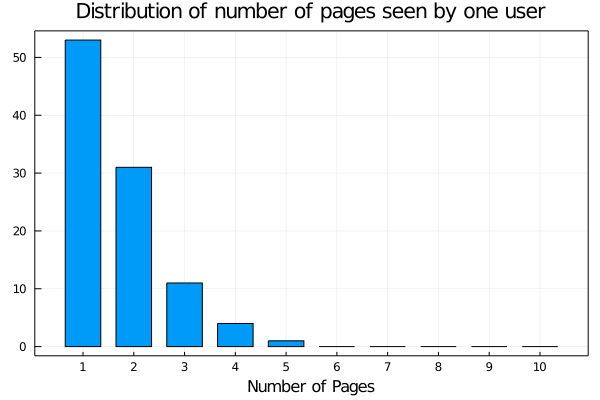

In [19]:
#
function pages_read_dist_histogram(mdp :: ContentProducerMdp)
    pages_num = length(mdp.pages)
    pages_seen_per_user = mdp.statistics.pages_seen_per_user
   pathes_length = [count((x)-> x==len,pages_seen_per_user) for len in 1:pages_num]
    groupedbar(1:pages_num,
            reshape(pathes_length,length(pathes_length),1),
            bar_position = :stack,
            bar_width=0.7,
            xticks =(1:pages_num),
            title="Distribution of number of pages seen by one user",
            xlabel="Number of Pages",
            leg=false,
            framestyle=:box) 
end

pages_read_dist_histogram(mdp1)


Now lets look at the distribution of the success/failure (next/leave) and the success ratio for each page.<br>
At the first histogram we present "next"s and "leave"s number in one bar for each one of 10 pages. <br>
At the second one we see the ration of the users that pressed "next" for each page.

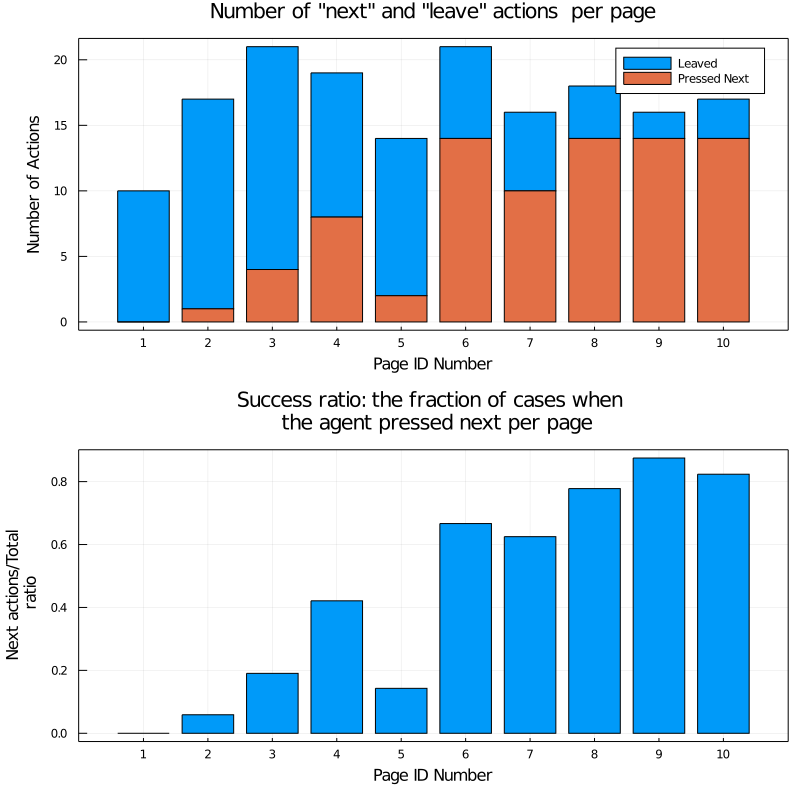

In [20]:
#
function action_distribution_hist(mdp:: ContentProducerMdp)
    
    pages_num = length(mdp.pages)
    stat = mdp.statistics
    
    
    hist_data = zeros(pages_num, 3)
    success_rate = zeros(pages_num)

pages_num = length(mdp.pages)
    
for page in mdp.pages
    nexts = stat.nexts_per_page[page.id]
    leaves = stat.leaves_per_page[page.id]
    total = nexts + leaves 
    hist_data[page.id,1] = nexts
    hist_data[page.id,2] = leaves

    if total > 0
        success_rate[page.id] =  nexts / total 
    end
end

g= groupedbar(hist_data,bar_position = :stack,
                    xlabel="Page ID Number",
                    ylabel="Number of Actions",
                    xticks =(1:pages_num),
                    title="Number of \"next\" and \"leave\" actions  per page",
                    framestyle=:box,
                    group=repeat(["Pressed Next","Leaved"],inner=pages_num))


g1 = groupedbar(reshape(success_rate,length(success_rate),1),
                    
                    xticks =(1:pages_num),
                    xlabel="Page ID Number",
                    ylabel=" Next actions/Total \n ratio",
                    title="Success ratio: the fraction of cases when \n the agent pressed next per page",
                    framestyle=:box,
                    leg=false)


plot(g,g1,size=(800,800),layout=(2,1))
    
end

action_distribution_hist(mdp1)

## Test 2 
<a id='test2'></a>
**Settings:** *10 pages, 100 same users, value iteration optimized policy, leaving probabilities for pages:*  $(0.1,0.2,...,1)$

We will use the same user and the same pages as in Test 1 , the only thing we will change is a policy. 

As in the previous section, there will be 10 pages, with leaving probabilities from 0.1 to 1 with step of 0.1. But now we will evaluate the states with value iteration, and then we will use greedy policy to run the experiment. 

In fact we know that the resulting policy should actually "arrange the pages by their leaving probabilities". The first action will show the page with the lowest leaving probability and the last one will be the page with the highest probability. It is actually the best policy possible.

##### The new MDP object

In [21]:
statistics2 = InitStatistics1(length(pages1))
mdp2 = ContentProducerMdp(pages1,user1,statistics2,false); # At the stage of value iteration the statistics collecting 
                                                          # will be off (the last argument)

##### Value iteration and optimal policy production

In [22]:
# initialize the solver
# belres: the value of Bellman residual used in the solver (defualt is 1e-3)
solver2 = ValueIterationSolver(max_iterations=100, belres=1e-3; verbose=true)

# solve for an optimal policy
policy2 = solve(solver2, mdp2);



[Iteration 1   ] residual:        100 | iteration runtime:    184.001 ms, (     0.184 s total)
[Iteration 2   ] residual:        0.9 | iteration runtime:     80.450 ms, (     0.264 s total)
[Iteration 3   ] residual:       0.72 | iteration runtime:     53.815 ms, (     0.318 s total)
[Iteration 4   ] residual:      0.504 | iteration runtime:     64.012 ms, (     0.382 s total)
[Iteration 5   ] residual:      0.302 | iteration runtime:     72.231 ms, (     0.455 s total)
[Iteration 6   ] residual:      0.151 | iteration runtime:     52.834 ms, (     0.507 s total)
[Iteration 7   ] residual:     0.0605 | iteration runtime:     52.233 ms, (      0.56 s total)
[Iteration 8   ] residual:     0.0181 | iteration runtime:     53.621 ms, (     0.613 s total)
[Iteration 9   ] residual:    0.00363 | iteration runtime:     63.724 ms, (     0.677 s total)
[Iteration 10  ] residual:   0.000363 | iteration runtime:     52.154 ms, (     0.729 s total)


##### Simulation
Now lets simulate 100 users arrivals and see how the results have changed. 

In [23]:
mdp2.statistics_on = true

rs2 = RolloutSimulator()
for _ in 1:100
    r = simulate(rs,mdp2,policy2)
end

#### Statistics and plots

In [24]:
#
totalPagesSeen2 =mdp2.statistics.total_pages_seen
averagePagesSeen2 = totalPagesSeen2/mdp2.statistics.users_number
println("====================================================================")
println("Total number of pages seen: $(totalPagesSeen2)")
println("The number of users: $(mdp2.statistics.users_number)")
println("Average number of pages seen per user: $averagePagesSeen2")
println("====================================================================")

Total number of pages seen: 388
The number of users: 100
Average number of pages seen per user: 3.88


The average number of pages viewed raised to more than 3.5 from about 1.6 in the random policy experiment. The distribution of the number of pages viewed looks completely different. Almost $1/4$ of the users arrived at more then 6 pages.

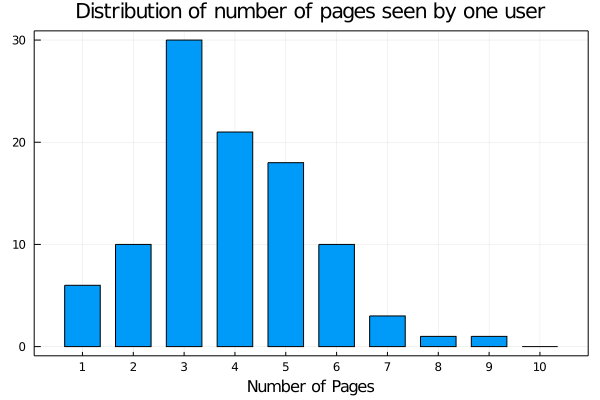

In [25]:
pages_read_dist_histogram(mdp2)

##  Temporary conclusion
<a id='conclude'></a>

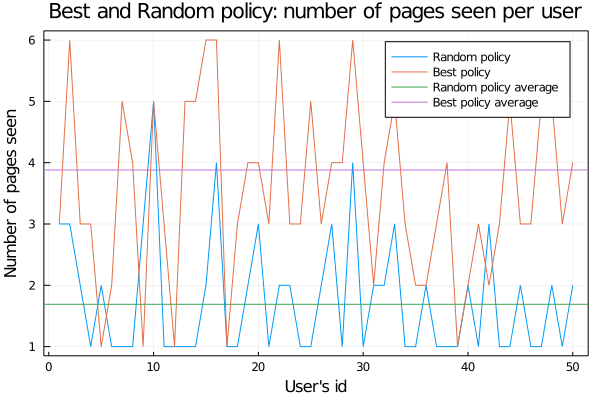

In [26]:
#
MAX_USERS = 50
pages_random = statistics1.pages_seen_per_user[1:MAX_USERS]
pages_best = statistics2.pages_seen_per_user[1:MAX_USERS]

pl = plot(1:MAX_USERS, pages_random,label="Random policy",xlabel="User's id",
                    ylabel="Number of pages seen",
                    title="Best and Random policy: number of pages seen per user",
                    framestyle=:box,)
plot!(pl,1:MAX_USERS, pages_best,label="Best policy")
hline!(pl,[averagePagesSeen1],label="Random policy average")
hline!(pl,[averagePagesSeen2],label="Best policy average")


We showed the behavior of two different policies in our MDP - the best and a random policy. It will be the benchmarks in our future work trying to find the best policy and trying to learn this policy in an optimal way. The goal remains the same: organizing the learning process such that the overall performance (Average number of pages read in multi-page publications) will be as good as possible for variable number of users and pages. The main fundamental issue here will be balancing exploration and exploitation. And the major measure of success will be the regret.   

# TiuTa / Chernovik

### Transition probabilities are known

Let's imagine the situation when the preferences of the visitor are known, and they are encapsulated in the probability of leaving for every particular page. It completely defines the transition function and the MDP . In this case the  problem is reduced to the planning problem.<br> 
These four characteristics made the current planning problem's solution trivial.
1. The transition function is independent of the pages the user has visited, and depend only on the current page shown. 
2. The states can't be repeated for each particular user, the user can see each page only once.
3. The user can traverse to exactly two states given some action,and one of them is $s_{final}$.
4. The reward depends only on the forthcoming state, and it is equal for all states except for the final.

Let's consider the state value function given any policy $\pi$.<br>
&emsp;$V(s_i) = \sum_{j}T(\pi(s_i),s_i,s_j)( R(\pi(s_i),s_i,s_j) + V(s_j) )$<br>
There is only one possible descending state with non-zero value for each action (The provider presents content to the visitor and she proceeds to the next page) and the reward is 1. As a result we can simplify the value function for our MDP:<br>
&emsp;$V(s_i) = T(\pi(s_i),s_i,s_j)( 1 + V(s_j) )$ ,<br> If we substitute the previous expression for each state into the value function of the initial state, we receive <br> 
&emsp;$V(s_{init}) =  T(\pi(s_{init}),s_{init},s_i)( 1 +  T(\pi(s_i),s_i,s_j)( 1 + \dots ) )$.<br>

Given the fact that: (1) each state can appear only once, (2) the transition probability depends only on the action, we can say that in order to maximize the value of $s_{init}$ (and as a result find an optimal policy) we need to arrange an actions in descending order by there transition probabilities. That is the optimal policy's action in the initial state will be $\arg\max_{\pi(s_{init})\in A} T(\pi(s_{init}),s_{init},s_i)$ and so on.<br>
<br>
As we said before, the planning problem turns to be trivial in case we know all the data.<br>
Now let's consider the case when our simplifying assumptions remain valid, but we don't know user's preferences.  


### Transition probabilities are unknown

Unknown content consumer's preferences mean that we don't know the exact probability of "leaving" for each particular page $c_i \in B$. In terms of the MDP it means that the transition function is unknown. But in fact it is only partially true. Given an action $a_{c_i}$ (showing to the user the page $c_i$), we know exactly the states that the process has non-zero probabilities to traverse to. This is the final state and the state that contains all the pages the user visited including the last one $c_i$. So actually we need to find only the probability of leaving after seeing each page and the MDP will be fully known.<br>
This problem turns to be a learning problem.<br>
Again, the problem's structure together with the assumptions makes it relatively simple learning problem. Despite the fact that there are $2^{|B|} + 2$ states, only actions have an impact on the transition probability. Thus we must estimate only $|B|$ values: the probabilities of leaving for each page. <br>

The simple "model learning -> planning" loop seems appropriate solution to deal it. But even though each step appears to be non-complicated, combining them together arise a fundamental exploration/exploitation dilemma.

